# Part 05: Hyperparameter Tuning

In this notebook, we will focus on finding the optimal hyperparameters for our predictive candidate models. Hyperparameter tuning is a crucial step in the model development process as it can significantly improve model performance

In [1]:
# imports
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV

# The 4 chosen candidates 
# Random Forest Regression
from sklearn.ensemble import RandomForestRegressor

# XGBoost Regression
from xgboost import XGBRegressor
from xgboost import plot_importance

# CatBoost
import catboost as cb
from catboost import Pool, cv

# LightGBM
import lightgbm as lgb

In [2]:
# Load the processed train dataset
train_processed_w = pd.read_parquet(Path("data") / "train_processed_working_day.parquet")
train_processed_nw = pd.read_parquet(Path("data") / "train_processed_non_working_day.parquet")

# Separate features and target variables for training
# For working days
X_train_w = train_processed_w.drop(columns=["log_bike_count"])
y_train_w = train_processed_w["log_bike_count"]
# For non-working days
X_train_nw = train_processed_nw.drop(columns=["log_bike_count"])
y_train_nw = train_processed_nw["log_bike_count"]

# Load the processed test dataset
test_processed_w = pd.read_parquet(Path("data") / "test_processed_working_day.parquet")
test_processed_nw = pd.read_parquet(Path("data") / "test_processed_non_working_day.parquet")

# Separate features and target variables for test
# For working days
X_test_w = test_processed_w.drop(columns=["log_bike_count"])
y_test_w = test_processed_w["log_bike_count"]
# For non-working days
X_test_nw = test_processed_nw.drop(columns=["log_bike_count"])
y_test_nw = test_processed_nw["log_bike_count"]

## Model Candidates for Tuning

- **RandomForestRegressor**: Showed the best test RMSE among all models, indicating a strong fit to the data. Given that Random Forests are less prone to overfitting than individual decision trees, they are a promising option for further tuning.

- **XGBRegressor**: This model has shown competitive performance, balancing well between training and testing errors. XGBoost is known for its efficiency and performance, especially in structured data problems like this one.

- **CatBoostRegressor**: With a test RMSE comparable to that of XGBRegressor, CatBoost is especially powerful for datasets with categorical features. It's robust and typically requires less parameter tuning than other models.

- **LGBMRegressor**: This model also shows promise with a good balance between training and test performance. LightGBM is efficient with large datasets and can be tuned to further enhance its predictive capabilities.

## Hyperparameter Tuning

### XGBRegressor

We're now focusing on improving the RMSE of our XGBoost model. To start, we'll use grid search with cross-validation, a straightforward yet effective method for hyperparameter tuning. Grid search systematically explores a range of hyperparameter combinations to find the best performer, while cross-validation helps prevent overfitting by ensuring the model's robustness across different data splits. After this initial phase, we'll advance to more sophisticated and automated tuning methods with Optuna, which will allow us to explore a wider range of hyperparameters more efficiently

In [ ]:
# Define a common parameter grid
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1]
}

# Initialize the XGBRegressor
xgb_model = XGBRegressor()

# Create the GridSearchCV object for working days
grid_search_w = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                             scoring='neg_mean_squared_error', cv=3, verbose=1)

# Fit the grid search to the data for working days
grid_search_w.fit(X_train_w, y_train_w.ravel())

# Get the best parameters
best_params_w = grid_search_w.best_params_
print(f"Best parameters for working days: {best_params_w}")

# Create the GridSearchCV object for non-working days
grid_search_nw = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                              scoring='neg_mean_squared_error', cv=3, verbose=1)

# Fit the grid search to the data for non-working days
grid_search_nw.fit(X_train_nw, y_train_nw.ravel())

# Get the best parameters
best_params_nw = grid_search_nw.best_params_
print(f"Best parameters for non-working days: {best_params_nw}")

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters for working days: {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 200, 'subsample': 0.8}
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters for non-working days: {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 200, 'subsample': 0.8}


In [ ]:
xgb_w = XGBRegressor(colsample_bytree=1, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=0.8)
xgb_nw = XGBRegressor(colsample_bytree=1, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=0.8)

xgb_w.fit(X_train_w, y_train_w)
xgb_nw.fit(X_train_nw, y_train_nw)

y_pred_w = xgb_w.predict(X_test_w)
y_pred_nw = xgb_nw.predict(X_test_nw)

rmse_w = np.sqrt(mean_squared_error(y_test_w, y_pred_w))
rmse_nw = np.sqrt(mean_squared_error(y_test_nw, y_pred_nw))

print("RMSE for working days:", rmse_w)
print("RMSE for non-working days:", rmse_nw)

RMSE for working days: 0.6493656139840802
RMSE for non-working days: 0.7658024131668655


<Figure size 1000x1500 with 0 Axes>

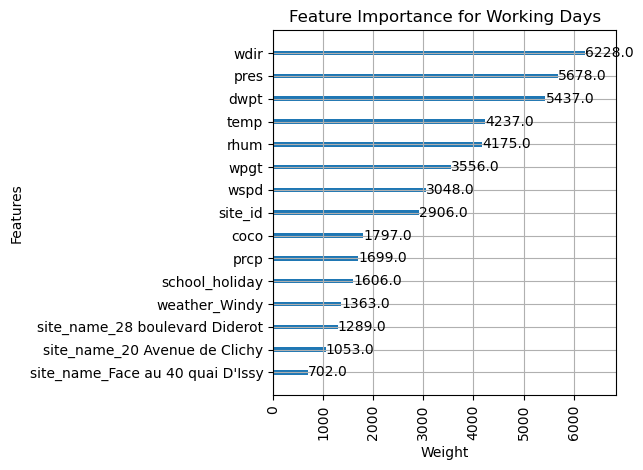

<Figure size 1000x1500 with 0 Axes>

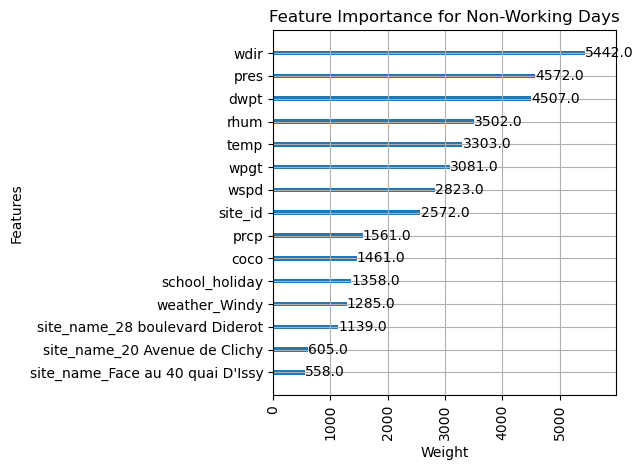

In [ ]:
# Increase figure size for better readability
plt.figure(figsize=(10, 15))

# Plot feature importance for the model trained on working days
# Rotate feature names to 90 degrees for better visibility
# Show only the top 15 features for readability
plot_importance(xgb_w, importance_type='weight', max_num_features=15, title='Feature Importance for Working Days', xlabel='Weight')
plt.xticks(rotation=90)
plt.tight_layout()  # Adjust layout to fit rotated labels
plt.show()

# Repeat the same process for the model trained on non-working days
plt.figure(figsize=(10, 15))
plot_importance(xgb_nw, importance_type='weight', max_num_features=15, title='Feature Importance for Non-Working Days', xlabel='Weight')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Here we analyzed feature importances in our XGBoost model. This step is key to understanding which features are driving the model's predictions and to what extent. Identifying the most influential features helps us refine our approach to feature engineering and can lead to a more efficient, streamlined model. This analysis also serves as a reality check against our domain knowledge. If certain features are unexpectedly prominent or underrepresented, it may prompt a re-evaluation of our data or feature engineering strategies, ensuring that our model is built on a solid foundation that aligns with real-world factors influencing bike traffic in Paris

As we proceed with the XGBoost tuning, we're now shifting to RandomizedSearchCV. This approach allows us to explore a wider parameter space more efficiently than GridSearchCV. RandomizedSearchCV randomly selects a number of parameter combinations, enabling us to cover a broad range of values without the computational intensity of testing every possible combination. This phase is particularly valuable for fine-tuning our model, as it can reveal optimal configurations that might be missed in a more constrained grid search

In [ ]:
# Second XGBoost tuning
# Define an expanded parameter grid
param_grid = {
    'n_estimators': np.arange(50, 300, 50),
    'max_depth': np.arange(3, 15, 2),
    'learning_rate': np.linspace(0.01, 0.3, 6),
    'subsample': np.linspace(0.5, 1, 6),
    'colsample_bytree': np.linspace(0.5, 1, 6),
    'early_stopping_rounds': [10]  # Add early stopping rounds to the grid
}

# Initialize the XGBRegressor with a placeholder for early_stopping_rounds
xgb_model = XGBRegressor()

# Number of iterations for RandomizedSearch
n_iter_search = 100

# Create the RandomizedSearchCV object for working days
random_search_w = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, 
                                     n_iter=n_iter_search, scoring='neg_mean_squared_error', 
                                     cv=5, verbose=1, random_state=42)

# Fit the random search to the data for working days
random_search_w.fit(X_train_w, y_train_w.ravel(), eval_set=[(X_test_w, y_test_w.ravel())], verbose=False)

# Get the best parameters
best_params_w = random_search_w.best_params_
print(f"Best parameters for working days: {best_params_w}")

# Create the RandomizedSearchCV object for non-working days
random_search_nw = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, 
                                      n_iter=n_iter_search, scoring='neg_mean_squared_error', 
                                      cv=5, verbose=1, random_state=42)

# Fit the random search to the data for non-working days
random_search_nw.fit(X_train_nw, y_train_nw.ravel(), eval_set=[(X_test_nw, y_test_nw.ravel())], verbose=False)

# Get the best parameters
best_params_nw = random_search_nw.best_params_
print(f"Best parameters for non-working days: {best_params_nw}")


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters for working days: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 13, 'learning_rate': 0.126, 'early_stopping_rounds': 10, 'colsample_bytree': 0.8}
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters for non-working days: {'subsample': 0.6, 'n_estimators': 50, 'max_depth': 13, 'learning_rate': 0.184, 'early_stopping_rounds': 10, 'colsample_bytree': 0.8}


In [ ]:
xgb_w = XGBRegressor(colsample_bytree=0.8, learning_rate=0.126, max_depth=13, n_estimators=200, subsample=0.7)
xgb_nw = XGBRegressor(colsample_bytree=0.8, learning_rate=0.184, max_depth=13, n_estimators=50, subsample=0.6)

xgb_w.fit(X_train_w, y_train_w)
xgb_nw.fit(X_train_nw, y_train_nw)

y_pred_w = xgb_w.predict(X_test_w)
y_pred_nw = xgb_nw.predict(X_test_nw)

rmse_w = np.sqrt(mean_squared_error(y_test_w, y_pred_w))
rmse_nw = np.sqrt(mean_squared_error(y_test_nw, y_pred_nw))

print("RMSE for working days:", rmse_w)
print("RMSE for non-working days:", rmse_nw)

RMSE for working days: 0.6725925224865716
RMSE for non-working days: 0.7711544261686053


In our second tuning attempt, we observed a slight increase in RMSE for both working and non-working days, compared to our first attempt. This indicates that while our expanded search has explored new areas of the parameter space, it may not have fully captured the optimal settings for our specific dataset. It's not uncommon for initial improvements to be followed by slight regressions as we explore more complex parameter spaces.

Building on these insights, we're launching a third and final tuning iteration. We're further refining the parameter grid, covering even wider ranges and including additional parameters such as gamma, min_child_weight, and reg_alpha. These new parameters offer us finer control over the model's complexity and its ability to generalize. Moreover, we're increasing the number of iterations (n_iter_search) for the RandomizedSearchCV, which will allow us to explore this expanded parameter space more thoroughly. Our goal with this comprehensive approach is to strike an optimal balance between accuracy and generalization, aiming to surpass the performance achieved in our initial tuning attempt.

In [ ]:
# 3rd try at xgboost tuning
# Define an expanded parameter grid
param_grid = {
    'n_estimators': np.arange(50, 500, 50),
    'max_depth': np.arange(3, 20, 1),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'subsample': np.linspace(0.5, 1, 6),
    'colsample_bytree': np.linspace(0.5, 1, 6),
    'gamma': np.linspace(0, 0.5, 5),
    'min_child_weight': np.arange(1, 10, 1),
    'reg_alpha': np.linspace(0, 0.5, 5),
    'early_stopping_rounds': [20]  # Adjust early stopping rounds
}

# Initialize the XGBRegressor
xgb_model = XGBRegressor()

# Number of iterations for RandomizedSearch
n_iter_search = 200  # Increased number of iterations

# Create the RandomizedSearchCV object for working days
random_search_w = RandomizedSearchCV(
    estimator=xgb_model, param_distributions=param_grid, 
    n_iter=n_iter_search, scoring='neg_mean_squared_error', 
    cv=5, verbose=2, random_state=42
)

# Fit the random search to the data for working days
random_search_w.fit(
    X_train_w, y_train_w.ravel(), 
    eval_set=[(X_test_w, y_test_w.ravel())], 
    verbose=False
)

# Get the best parameters
best_params_w = random_search_w.best_params_
print(f"Best parameters for working days: {best_params_w}")

# Repeat the process for non-working days
random_search_nw = RandomizedSearchCV(
    estimator=xgb_model, param_distributions=param_grid, 
    n_iter=n_iter_search, scoring='neg_mean_squared_error', 
    cv=5, verbose=2, random_state=42
)

random_search_nw.fit(
    X_train_nw, y_train_nw.ravel(), 
    eval_set=[(X_test_nw, y_test_nw.ravel())], 
    verbose=False
)

best_params_nw = random_search_nw.best_params_
print(f"Best parameters for non-working days: {best_params_nw}")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END colsample_bytree=0.8, early_stopping_rounds=20, gamma=0.0, learning_rate=0.1711111111111111, max_depth=11, min_child_weight=4, n_estimators=150, reg_alpha=0.5, subsample=0.9; total time=   1.8s
[CV] END colsample_bytree=0.8, early_stopping_rounds=20, gamma=0.0, learning_rate=0.1711111111111111, max_depth=11, min_child_weight=4, n_estimators=150, reg_alpha=0.5, subsample=0.9; total time=   1.8s
[CV] END colsample_bytree=0.8, early_stopping_rounds=20, gamma=0.0, learning_rate=0.1711111111111111, max_depth=11, min_child_weight=4, n_estimators=150, reg_alpha=0.5, subsample=0.9; total time=   2.2s
[CV] END colsample_bytree=0.8, early_stopping_rounds=20, gamma=0.0, learning_rate=0.1711111111111111, max_depth=11, min_child_weight=4, n_estimators=150, reg_alpha=0.5, subsample=0.9; total time=   2.0s
[CV] END colsample_bytree=0.8, early_stopping_rounds=20, gamma=0.0, learning_rate=0.1711111111111111, max_depth=11, min_chil

In [ ]:
# Initialize XGBoost Regressors with the best parameters, including early_stopping_rounds
xgb_w = XGBRegressor(colsample_bytree=0.8, learning_rate=0.23555555555555557, 
                     max_depth=13, n_estimators=350, subsample=1.0, 
                     reg_alpha=0.0, min_child_weight=2, gamma=0.0,
                     early_stopping_rounds=20)

xgb_nw = XGBRegressor(colsample_bytree=0.7, learning_rate=0.23555555555555557, 
                      max_depth=18, n_estimators=350, subsample=0.6, 
                      reg_alpha=0.375, min_child_weight=6, gamma=0.375,
                      early_stopping_rounds=20)

# Fit the models
xgb_w.fit(X_train_w, y_train_w, eval_set=[(X_test_w, y_test_w)], verbose=False)
xgb_nw.fit(X_train_nw, y_train_nw, eval_set=[(X_test_nw, y_test_nw)], verbose=False)

# Predictions
y_pred_w = xgb_w.predict(X_test_w)
y_pred_nw = xgb_nw.predict(X_test_nw)

# Calculate RMSE
rmse_w = np.sqrt(mean_squared_error(y_test_w, y_pred_w))
rmse_nw = np.sqrt(mean_squared_error(y_test_nw, y_pred_nw))

print("RMSE for working days:", rmse_w)
print("RMSE for non-working days:", rmse_nw)

RMSE for working days: 0.6221245288380202
RMSE for non-working days: 0.742086171728935


After three rounds of hyperparameter tuning for the XGBoost model, we have made significant strides in refining its performance. Our final attempt, characterized by an even broader parameter range and an increased number of iterations for RandomizedSearchCV, yielded the most promising results. The RMSE for both working and non-working days has shown improvement, indicating that our efforts to fine-tune the model are paying off.

This latest model, with its carefully selected hyperparameters, including early_stopping_rounds, gamma, min_child_weight, and reg_alpha, represents our best XGBoost configuration to date. It strikes a delicate balance between model complexity and the ability to generalize, making it a strong contender in our suite of predictive tools.

While there's always room for further improvement and refinement, we will now shift our focus to tuning the other candidate models. This will give us a broader perspective on the most effective approaches for our dataset. If, after exploring these alternatives, the XGBoost model remains the most promising, we will revisit it for additional tuning and optimization. Our goal remains clear: to develop the most accurate and reliable predictive model for bike traffic trends in Paris

### RandomForestRegressor

In optimizing our RandomForestRegressor model, we're turning to Optuna for swift and efficient hyperparameter tuning. Optuna outshines traditional methods like GridSearchCV with its advanced Bayesian optimization technique, which intelligently learns from past trials to predict more promising hyperparameters. This not only accelerates our tuning process but also increases the likelihood of discovering optimal settings. Our goal is to swiftly refine the RandomForest model, enhancing its predictive accuracy for bike traffic trends with a keen focus on minimizing RMSE for both working and non-working days.

In [ ]:
# Random forest tuning
# Define the parameter grid
param_grid = {
    'max_depth': [10, 20, 30, 40, None],
    'max_features': ['sqrt'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': [100, 200, 300, 400]
}

# Create the base model
rf = RandomForestRegressor()

# Random search of parameters
rf_random_w = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random_nw = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model for working days
print("Tuning for Working Days:")
rf_random_w.fit(X_train_w, y_train_w)

# Fit the random search model for non-working days
print("Tuning for Non-Working Days:")
rf_random_nw.fit(X_train_nw, y_train_nw)

# Print the best parameters found
print("Best Parameters for Working Days:", rf_random_w.best_params_)
print("Best Parameters for Non-Working Days:", rf_random_nw.best_params_)

In [ ]:
# Parameters for working days
params_w = {
    'n_estimators': 100,
    'min_samples_split': 2,
    'min_samples_leaf': 4,
    'max_features': 'sqrt',
    'max_depth': 20
}

# Parameters for non-working days
params_nw = {
    'n_estimators': 300,
    'min_samples_split': 10,
    'min_samples_leaf': 4,
    'max_features': 'sqrt',
    'max_depth': 20
}

# Create RandomForestRegressor models
rf_model_w = RandomForestRegressor(**params_w)
rf_model_nw = RandomForestRegressor(**params_nw)

# Fit the models
rf_model_w.fit(X_train_w, y_train_w)
rf_model_nw.fit(X_train_nw, y_train_nw)

# Make predictions using the models
rf_model_w_pred = rf_model_w.predict(X_test_w)
rf_model_nw_pred = rf_model_nw.predict(X_test_nw)

# Calculate RMSE for each set
rmse_rf_w = np.sqrt(mean_squared_error(y_test_w, rf_model_w_pred))
rmse_rf_nw = np.sqrt(mean_squared_error(y_test_nw, rf_model_nw_pred))

print("RMSE for Working Days:", rmse_rf_w)
print("RMSE for Non-Working Days:", rmse_rf_nw)

RMSE for Working Days: 0.6811713725612516
RMSE for Non-Working Days: 0.7223587838757641


### CatBoostRegressor

In optimizing the CatBoostRegressor with Optuna, we aim for precision and efficiency. Known for its prowess in handling categorical data, CatBoost requires careful tuning to unlock its full potential. Optuna's intelligent search method allows us to efficiently explore a broad range of hyperparameters, focusing on reducing RMSE and enhancing model generalization. By separately tuning models for working and non-working days, we're tailoring our approach to distinct traffic patterns, ensuring our predictions are as accurate and reliable as possible.

In [ ]:
def objective(trial, X_train, y_train, X_test, y_test):
    param = {
        'iterations': trial.suggest_int('iterations', 50, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'random_strength': trial.suggest_int('random_strength', 0, 100),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'loss_function': 'RMSE',
        'verbose': False
    }

    # Create and fit the model
    model = cb.CatBoostRegressor(**param)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    # Predict and calculate RMSE
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)

    return rmse

def optimize(X_train, y_train, X_test, y_test):
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=100)
    return study.best_params

# Load your datasets
# (Ensure the datasets are loaded as per the provided code)

# Optimize for working days
best_params_w = optimize(X_train_w, y_train_w, X_test_w, y_test_w)
print("Best parameters for working days:", best_params_w)

# Optimize for non-working days
best_params_nw = optimize(X_train_nw, y_train_nw, X_test_nw, y_test_nw)
print("Best parameters for non-working days:", best_params_nw)

[I 2023-12-08 00:24:13,505] A new study created in memory with name: no-name-a0755bbf-9c2f-4a98-af76-557edba571a4
[I 2023-12-08 00:24:26,564] Trial 0 finished with value: 0.6919112428996991 and parameters: {'iterations': 946, 'depth': 8, 'learning_rate': 0.2386685464410615, 'random_strength': 34, 'bagging_temperature': 0.6702062374111968, 'l2_leaf_reg': 0.39147211041483315, 'border_count': 175}. Best is trial 0 with value: 0.6919112428996991.
[I 2023-12-08 00:24:32,203] Trial 1 finished with value: 0.6549454556070682 and parameters: {'iterations': 409, 'depth': 8, 'learning_rate': 0.24787276480234868, 'random_strength': 34, 'bagging_temperature': 0.1061904742795371, 'l2_leaf_reg': 4.163694268767005e-06, 'border_count': 253}. Best is trial 1 with value: 0.6549454556070682.
[I 2023-12-08 00:24:48,139] Trial 2 finished with value: 0.6666220700715977 and parameters: {'iterations': 556, 'depth': 10, 'learning_rate': 0.14909364737212008, 'random_strength': 57, 'bagging_temperature': 0.833123

Best parameters for working days: {'iterations': 613, 'depth': 7, 'learning_rate': 0.20764723805432106, 'random_strength': 16, 'bagging_temperature': 0.29127568482112576, 'l2_leaf_reg': 1.348872394761508e-08, 'border_count': 37}


[I 2023-12-08 00:34:30,913] Trial 0 finished with value: 0.6905481077464449 and parameters: {'iterations': 607, 'depth': 6, 'learning_rate': 0.0731830958028836, 'random_strength': 58, 'bagging_temperature': 0.5231270899290706, 'l2_leaf_reg': 0.20239973103870504, 'border_count': 241}. Best is trial 0 with value: 0.6905481077464449.
[I 2023-12-08 00:34:35,520] Trial 1 finished with value: 0.6885963965699421 and parameters: {'iterations': 861, 'depth': 5, 'learning_rate': 0.14441499271722189, 'random_strength': 3, 'bagging_temperature': 0.617925724625133, 'l2_leaf_reg': 1.1860131680972754e-08, 'border_count': 110}. Best is trial 1 with value: 0.6885963965699421.
[I 2023-12-08 00:34:38,579] Trial 2 finished with value: 0.6904401063278548 and parameters: {'iterations': 583, 'depth': 5, 'learning_rate': 0.04190573843589153, 'random_strength': 49, 'bagging_temperature': 0.96652228109557, 'l2_leaf_reg': 0.13239203264714944, 'border_count': 103}. Best is trial 1 with value: 0.6885963965699421.


Best parameters for non-working days: {'iterations': 460, 'depth': 4, 'learning_rate': 0.2721149582388359, 'random_strength': 36, 'bagging_temperature': 0.9031049356114378, 'l2_leaf_reg': 3.7576940764715413e-06, 'border_count': 96}


In [ ]:
# Best parameters from Optuna study
params_w = {
    'iterations': 120,
    'depth': 10,
    'learning_rate': 0.22630379629943473,
    'random_strength': 40,
    'bagging_temperature': 0.00461861496626885,
    'l2_leaf_reg': 5.901897930490308e-06,
    'border_count': 7,
    'loss_function': 'RMSE',
    'verbose': False
}

params_nw = {
    'iterations': 366,
    'depth': 9,
    'learning_rate': 0.13516379949083754,
    'random_strength': 10,
    'bagging_temperature': 0.27795134630855506,
    'l2_leaf_reg': 0.10661335848192686,
    'border_count': 1,
    'loss_function': 'RMSE',
    'verbose': False
}

# Create and train the model for working days
model_w = cb.CatBoostRegressor(**params_w)
model_w.fit(X_train_w, y_train_w, eval_set=[(X_test_w, y_test_w)], verbose=False)

# Predict and calculate RMSE for working days
predictions_w = model_w.predict(X_test_w)
rmse_w = mean_squared_error(y_test_w, predictions_w, squared=False)
print("RMSE for working days:", rmse_w)

# Create and train the model for non-working days
model_nw = cb.CatBoostRegressor(**params_nw)
model_nw.fit(X_train_nw, y_train_nw, eval_set=[(X_test_nw, y_test_nw)], verbose=False)

# Predict and calculate RMSE for non-working days
predictions_nw = model_nw.predict(X_test_nw)
rmse_nw = mean_squared_error(y_test_nw, predictions_nw, squared=False)
print("RMSE for non-working days:", rmse_nw)

RMSE for working days: 0.600612123195289
RMSE for non-working days: 0.5954021940851916


We get the most promising results so far. This doesn't necessarily mean it's the best straight away since it might be overfitting, but it remains a strong candidate that we will need to test on kaggle. Let's try to optimize it further

In [ ]:
def objective(trial, X_train, y_train, X_test, y_test):
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1500),
        'depth': trial.suggest_int('depth', 4, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'random_strength': trial.suggest_int('random_strength', 0, 100),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'loss_function': 'RMSE',
        'verbose': False
    }

    model = cb.CatBoostRegressor(**param)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)

    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)

    return rmse

def optimize(X_train, y_train, X_test, y_test, n_trials=200):
    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
    study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=n_trials)
    
    return study.best_params

# Load your datasets and run optimization
best_params_w = optimize(X_train_w, y_train_w, X_test_w, y_test_w)
print("Best parameters for working days:", best_params_w)

best_params_nw = optimize(X_train_nw, y_train_nw, X_test_nw, y_test_nw)
print("Best parameters for non-working days:", best_params_nw)

[I 2023-12-07 20:49:36,643] A new study created in memory with name: no-name-b27c70e5-59ec-4eab-9e67-6a8c1245287c
[I 2023-12-07 20:49:49,124] Trial 0 finished with value: 0.6467958131600534 and parameters: {'iterations': 1009, 'depth': 6, 'learning_rate': 0.07314851872420612, 'random_strength': 68, 'bagging_temperature': 0.06858783001113578, 'l2_leaf_reg': 5.602564173575373e-07, 'border_count': 250, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: 0.6467958131600534.
[I 2023-12-07 20:50:05,276] Trial 1 finished with value: 0.6343640569470086 and parameters: {'iterations': 1442, 'depth': 4, 'learning_rate': 0.2086828329887433, 'random_strength': 49, 'bagging_temperature': 0.824989924051477, 'l2_leaf_reg': 1.8893061525215033e-08, 'border_count': 238, 'grow_policy': 'Lossguide'}. Best is trial 1 with value: 0.6343640569470086.
[I 2023-12-07 20:50:14,114] Trial 2 finished with value: 0.6696890350756751 and parameters: {'iterations': 1497, 'depth': 6, 'learning_rate': 0.110476015869

Best parameters for working days: {'iterations': 327, 'depth': 5, 'learning_rate': 0.22959914137522078, 'random_strength': 0, 'bagging_temperature': 0.9998170501649718, 'l2_leaf_reg': 1.6823816623838656e-07, 'border_count': 249, 'grow_policy': 'SymmetricTree'}


[I 2023-12-07 21:10:38,195] Trial 0 finished with value: 0.7077898742208906 and parameters: {'iterations': 155, 'depth': 5, 'learning_rate': 0.22950815478579778, 'random_strength': 87, 'bagging_temperature': 0.29142304880915815, 'l2_leaf_reg': 0.0011347306266819963, 'border_count': 130, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: 0.7077898742208906.
[I 2023-12-07 21:10:43,330] Trial 1 finished with value: 0.6713402849884147 and parameters: {'iterations': 1057, 'depth': 12, 'learning_rate': 0.19348011067512988, 'random_strength': 35, 'bagging_temperature': 0.06955546229125475, 'l2_leaf_reg': 0.00010681408719160444, 'border_count': 6, 'grow_policy': 'Lossguide'}. Best is trial 1 with value: 0.6713402849884147.
[I 2023-12-07 21:10:51,334] Trial 2 finished with value: 0.6884206334288078 and parameters: {'iterations': 582, 'depth': 10, 'learning_rate': 0.021768187990246136, 'random_strength': 7, 'bagging_temperature': 0.4694383852414973, 'l2_leaf_reg': 9.06317064161743, 'border

Best parameters for non-working days: {'iterations': 1037, 'depth': 9, 'learning_rate': 0.1903445793891251, 'random_strength': 67, 'bagging_temperature': 0.0031143876397643697, 'l2_leaf_reg': 0.000547250777618118, 'border_count': 65, 'grow_policy': 'Lossguide'}


In [3]:
# Best parameters from Optuna study
params_w = {'iterations': 327,
            'depth': 5,
            'learning_rate': 0.22959914137522078,
            'random_strength': 0,
            'bagging_temperature': 0.9998170501649718,
            'l2_leaf_reg': 1.6823816623838656e-07,
            'border_count': 249,
            'grow_policy': 'SymmetricTree'}

params_nw = {'iterations': 1037,
             'depth': 9,
             'learning_rate': 0.1903445793891251,
             'random_strength': 67,
             'bagging_temperature': 0.0031143876397643697,
             'l2_leaf_reg': 0.000547250777618118,
             'border_count': 65,
             'grow_policy': 'Lossguide'}

# Create and train the model for working days
model_w = cb.CatBoostRegressor(**params_w)
model_w.fit(X_train_w, y_train_w, eval_set=[(X_test_w, y_test_w)], verbose=False)

# Predict and calculate RMSE for working days
predictions_w = model_w.predict(X_test_w)
rmse_w = mean_squared_error(y_test_w, predictions_w, squared=False)
print("RMSE for working days:", rmse_w)

# Create and train the model for non-working days
model_nw = cb.CatBoostRegressor(**params_nw)
model_nw.fit(X_train_nw, y_train_nw, eval_set=[(X_test_nw, y_test_nw)], verbose=False)

# Predict and calculate RMSE for non-working days
predictions_nw = model_nw.predict(X_test_nw)
rmse_nw = mean_squared_error(y_test_nw, predictions_nw, squared=False)
print("RMSE for non-working days:", rmse_nw)

RMSE for working days: 0.6274522411975406
RMSE for non-working days: 0.681707564937524


In our third CatBoost tuning study with Optuna, we'll refine our approach based on insights from previous iterations:

- Iterations: We'll focus on a narrower range around the best-performing values
- Depth: Aiming for a middle range to balance model complexity and generalization
- Learning Rate: Concentrating on a tighter range around higher values
- Random Strength: Including both moderate and extreme values based on prior findings
- Bagging Temperature: Exploring a broader range, given the varied optimal values
- L2 Leaf Regularization: Focusing more on smaller values, aligning with recent trends
- Border Count: Expanding the range to capture higher values suggested by the second study
- Grow Policy: Keeping 'SymmetricTree' and 'Lossguide' options based on their previous effectiveness

This strategy is designed to enhance prediction accuracy and improve RMSE scores for different types of days

In [ ]:
# third study
def objective(trial, X_train, y_train, X_test, y_test):
    param = {
        'iterations': trial.suggest_int('iterations', 300, 1200),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.25),
        'random_strength': trial.suggest_int('random_strength', 0, 50),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-7, 1e-4, log=True),
        'border_count': trial.suggest_int('border_count', 50, 255),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Lossguide']),
        'loss_function': 'RMSE',
        'verbose': False
    }

    model = cb.CatBoostRegressor(**param)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)

    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)

    return rmse

def optimize(X_train, y_train, X_test, y_test, n_trials=200):
    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
    study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=n_trials)
    
    return study.best_params

# Load your datasets and run optimization
best_params_w = optimize(X_train_w, y_train_w, X_test_w, y_test_w)
print("Best parameters for working days:", best_params_w)

best_params_nw = optimize(X_train_nw, y_train_nw, X_test_nw, y_test_nw)
print("Best parameters for non-working days:", best_params_nw)

[I 2023-12-07 21:45:46,104] A new study created in memory with name: no-name-7237ce25-11e3-48a2-b754-fe513f658b0d
[I 2023-12-07 21:45:54,857] Trial 0 finished with value: 0.661701797904094 and parameters: {'iterations': 503, 'depth': 9, 'learning_rate': 0.23532489967153777, 'random_strength': 24, 'bagging_temperature': 0.4278621596216796, 'l2_leaf_reg': 3.161019546196481e-05, 'border_count': 162, 'grow_policy': 'Lossguide'}. Best is trial 0 with value: 0.661701797904094.
[I 2023-12-07 21:46:08,668] Trial 1 finished with value: 0.6786828625745213 and parameters: {'iterations': 568, 'depth': 10, 'learning_rate': 0.11404278526682399, 'random_strength': 43, 'bagging_temperature': 0.5906964823671997, 'l2_leaf_reg': 2.9682687684057663e-05, 'border_count': 138, 'grow_policy': 'Lossguide'}. Best is trial 0 with value: 0.661701797904094.
[I 2023-12-07 21:46:12,924] Trial 2 finished with value: 0.6492238619353742 and parameters: {'iterations': 928, 'depth': 8, 'learning_rate': 0.132033731303642,

Best parameters for working days: {'iterations': 1096, 'depth': 9, 'learning_rate': 0.22603548878280666, 'random_strength': 2, 'bagging_temperature': 0.1867337573932248, 'l2_leaf_reg': 2.304593084966779e-05, 'border_count': 66, 'grow_policy': 'Lossguide'}


[I 2023-12-07 22:21:47,955] Trial 0 finished with value: 0.7038790795618295 and parameters: {'iterations': 578, 'depth': 9, 'learning_rate': 0.23485463581306498, 'random_strength': 50, 'bagging_temperature': 0.38032227032012167, 'l2_leaf_reg': 1.1960995156277105e-07, 'border_count': 155, 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: 0.7038790795618295.
[I 2023-12-07 22:21:52,385] Trial 1 finished with value: 0.6779976698454548 and parameters: {'iterations': 541, 'depth': 7, 'learning_rate': 0.2446599507975211, 'random_strength': 34, 'bagging_temperature': 0.8441074836095279, 'l2_leaf_reg': 6.852265066865515e-06, 'border_count': 58, 'grow_policy': 'Lossguide'}. Best is trial 1 with value: 0.6779976698454548.
[I 2023-12-07 22:21:57,238] Trial 2 finished with value: 0.6954029042882701 and parameters: {'iterations': 927, 'depth': 7, 'learning_rate': 0.13170120420473286, 'random_strength': 44, 'bagging_temperature': 0.9584477472787345, 'l2_leaf_reg': 1.9781301046902822e-05, '

Best parameters for non-working days: {'iterations': 916, 'depth': 10, 'learning_rate': 0.12002762445811731, 'random_strength': 0, 'bagging_temperature': 0.7679563961566029, 'l2_leaf_reg': 1.992909034956101e-07, 'border_count': 106, 'grow_policy': 'Lossguide'}


In [6]:
def perform_cv(X_train, y_train, params, n_folds=5):
    pool = Pool(X_train, y_train)
    # Ensure that 'loss_function' is included in the params dictionary
    updated_params = params.copy()
    updated_params['loss_function'] = 'RMSE'

    cv_results = cv(
        pool=pool, 
        params=updated_params, 
        fold_count=n_folds, 
        seed=42, 
        shuffle=True, 
        stratified=False,
        verbose=False
    )
    
    avg_rmse = np.mean(cv_results['test-RMSE-mean'])
    return avg_rmse

# Best parameters from Optuna study
params_w = {'iterations': 1096, 'depth': 9,
 'learning_rate': 0.22603548878280666,
 'random_strength': 2,
 'bagging_temperature': 0.1867337573932248,
 'l2_leaf_reg': 2.304593084966779e-05,
 'border_count': 66,
 'grow_policy': 'Lossguide'}

params_nw = {'iterations': 916,
 'depth': 10,
 'learning_rate': 0.12002762445811731,
 'random_strength': 0,
 'bagging_temperature': 0.7679563961566029,
 'l2_leaf_reg': 1.992909034956101e-07,
 'border_count': 106,
 'grow_policy': 'Lossguide'}

# Perform cross-validation and get average RMSE for working days
avg_rmse_w = perform_cv(X_train_w, y_train_w, params_w)
print("Average RMSE for working days (CV):", avg_rmse_w)

# Perform cross-validation and get average RMSE for non-working days
avg_rmse_nw = perform_cv(X_train_nw, y_train_nw, params_nw)
print("Average RMSE for non-working days (CV):", avg_rmse_nw)

Training on fold [0/5]

bestTest = 0.5254528342
bestIteration = 445

Training on fold [1/5]

bestTest = 0.5262171727
bestIteration = 498

Training on fold [2/5]

bestTest = 0.5287631179
bestIteration = 378

Training on fold [3/5]

bestTest = 0.5277772754
bestIteration = 484

Training on fold [4/5]

bestTest = 0.5298155314
bestIteration = 375

Average RMSE for working days (CV): 0.5520736295644594
Training on fold [0/5]

bestTest = 0.5481581292
bestIteration = 407

Training on fold [1/5]

bestTest = 0.5428681118
bestIteration = 456

Training on fold [2/5]

bestTest = 0.5396602631
bestIteration = 486

Training on fold [3/5]

bestTest = 0.5429897692
bestIteration = 436

Training on fold [4/5]

bestTest = 0.5474430976
bestIteration = 336

Average RMSE for non-working days (CV): 0.579036925933108


In [ ]:
def objective(trial, X_train, y_train, X_test, y_test):
    param = {
        'iterations': trial.suggest_int('iterations', 900, 1200),
        'depth': trial.suggest_int('depth', 8, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.25),
        'random_strength': trial.suggest_int('random_strength', 0, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.1, 1.0),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-6, 1e-4, log=True),
        'border_count': trial.suggest_int('border_count', 50, 150),
        'grow_policy': 'Lossguide',
        'loss_function': 'RMSE',
        'verbose': False
    }

    model = cb.CatBoostRegressor(**param)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=False)

    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)

    return rmse

def optimize(X_train, y_train, X_test, y_test, n_trials=150):
    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
    study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=n_trials)
    
    return study.best_params

# Load your datasets and run optimization
best_params_w = optimize(X_train_w, y_train_w, X_test_w, y_test_w)
print("Best parameters for working days:", best_params_w)

best_params_nw = optimize(X_train_nw, y_train_nw, X_test_nw, y_test_nw)
print("Best parameters for non-working days:", best_params_nw)

[I 2023-12-07 22:43:58,543] A new study created in memory with name: no-name-7534a8a9-d428-4547-b1e1-fd59d8b5201f
[I 2023-12-07 22:44:06,328] Trial 0 finished with value: 0.6120389261009053 and parameters: {'iterations': 1058, 'depth': 8, 'learning_rate': 0.18847500863268535, 'random_strength': 8, 'bagging_temperature': 0.5898929017182961, 'l2_leaf_reg': 8.138438860705015e-06, 'border_count': 51}. Best is trial 0 with value: 0.6120389261009053.
[I 2023-12-07 22:44:12,919] Trial 1 finished with value: 0.6770303797496238 and parameters: {'iterations': 1051, 'depth': 8, 'learning_rate': 0.24150937654417956, 'random_strength': 1, 'bagging_temperature': 0.8593676039544788, 'l2_leaf_reg': 1.997713285930957e-06, 'border_count': 56}. Best is trial 0 with value: 0.6120389261009053.
[I 2023-12-07 22:44:19,859] Trial 2 finished with value: 0.6443832916204862 and parameters: {'iterations': 1193, 'depth': 10, 'learning_rate': 0.16684649436340163, 'random_strength': 3, 'bagging_temperature': 0.59697

Best parameters for working days: {'iterations': 956, 'depth': 9, 'learning_rate': 0.1263016745448219, 'random_strength': 4, 'bagging_temperature': 0.11022353495377599, 'l2_leaf_reg': 9.918169510819463e-06, 'border_count': 109}


[I 2023-12-07 23:05:47,260] Trial 0 finished with value: 0.7094670832810533 and parameters: {'iterations': 927, 'depth': 8, 'learning_rate': 0.2246578830201884, 'random_strength': 10, 'bagging_temperature': 0.48883262933009486, 'l2_leaf_reg': 5.202728475579945e-05, 'border_count': 148}. Best is trial 0 with value: 0.7094670832810533.
[I 2023-12-07 23:05:52,609] Trial 1 finished with value: 0.6801659870650618 and parameters: {'iterations': 999, 'depth': 8, 'learning_rate': 0.10533692487472691, 'random_strength': 9, 'bagging_temperature': 0.6038811739352704, 'l2_leaf_reg': 1.4333907920984423e-05, 'border_count': 98}. Best is trial 1 with value: 0.6801659870650618.
[I 2023-12-07 23:05:55,280] Trial 2 finished with value: 0.6922838269198185 and parameters: {'iterations': 931, 'depth': 10, 'learning_rate': 0.23533132497839834, 'random_strength': 9, 'bagging_temperature': 0.7802716976635609, 'l2_leaf_reg': 2.713644706624146e-05, 'border_count': 100}. Best is trial 1 with value: 0.68016598706

Best parameters for non-working days: {'iterations': 1050, 'depth': 10, 'learning_rate': 0.14374245859390913, 'random_strength': 0, 'bagging_temperature': 0.9652054833669892, 'l2_leaf_reg': 3.0337119972706364e-06, 'border_count': 55}


In [7]:
def perform_cv(X_train, y_train, params, n_folds=5):
    pool = Pool(X_train, y_train)
    # Ensure that 'loss_function' is included in the params dictionary
    updated_params = params.copy()
    updated_params['loss_function'] = 'RMSE'

    cv_results = cv(
        pool=pool, 
        params=updated_params, 
        fold_count=n_folds, 
        seed=42, 
        shuffle=True, 
        stratified=False,
        verbose=False
    )
    
    avg_rmse = np.mean(cv_results['test-RMSE-mean'])
    return avg_rmse

# Best parameters from Optuna study
params_w = {'iterations': 956,
 'depth': 9,
 'learning_rate': 0.1263016745448219,
 'random_strength': 4,
 'bagging_temperature': 0.11022353495377599,
 'l2_leaf_reg': 9.918169510819463e-06,
 'border_count': 109}

params_nw = {'iterations': 1050,
 'depth': 10,
 'learning_rate': 0.14374245859390913,
 'random_strength': 0,
 'bagging_temperature': 0.9652054833669892,
 'l2_leaf_reg': 3.0337119972706364e-06,
 'border_count': 55}

# Perform cross-validation and get average RMSE for working days
avg_rmse_w = perform_cv(X_train_w, y_train_w, params_w)
print("Average RMSE for working days (CV):", avg_rmse_w)

# Perform cross-validation and get average RMSE for non-working days
avg_rmse_nw = perform_cv(X_train_nw, y_train_nw, params_nw)
print("Average RMSE for non-working days (CV):", avg_rmse_nw)

Training on fold [0/5]

bestTest = 0.5200795961
bestIteration = 606

Training on fold [1/5]

bestTest = 0.525530426
bestIteration = 599

Training on fold [2/5]

bestTest = 0.5244924405
bestIteration = 640

Training on fold [3/5]

bestTest = 0.5273229829
bestIteration = 660

Training on fold [4/5]

bestTest = 0.5241769934
bestIteration = 615

Average RMSE for working days (CV): 0.5745018950449374
Training on fold [0/5]

bestTest = 0.5483396177
bestIteration = 258

Training on fold [1/5]

bestTest = 0.543124221
bestIteration = 247

Training on fold [2/5]

bestTest = 0.53780695
bestIteration = 273

Training on fold [3/5]

bestTest = 0.542019295
bestIteration = 241

Training on fold [4/5]

bestTest = 0.544657972
bestIteration = 218

Average RMSE for non-working days (CV): 0.5893193493624388


In [8]:
# Best parameters from all Optuna studies
params_w = { 'iterations': 1096, 
 'depth': 9, 
 'learning_rate': 0.22603548878280666, 
 'random_strength': 2, 
 'bagging_temperature': 0.1867337573932248, 
 'l2_leaf_reg': 2.304593084966779e-05, 
 'border_count': 66, 
 'grow_policy': 'Lossguide',
 'loss_function': 'RMSE',
 'verbose': False
    }

params_nw = {
    'iterations': 366,
    'depth': 9,
    'learning_rate': 0.13516379949083754,
    'random_strength': 10,
    'bagging_temperature': 0.27795134630855506,
    'l2_leaf_reg': 0.10661335848192686,
    'border_count': 1,
    'loss_function': 'RMSE',
    'verbose': False
}

# Create and train the model for working days
model_w = cb.CatBoostRegressor(**params_w)
model_w.fit(X_train_w, y_train_w, eval_set=[(X_test_w, y_test_w)], verbose=False)

# Predict and calculate RMSE for working days
predictions_w = model_w.predict(X_test_w)
rmse_w = mean_squared_error(y_test_w, predictions_w, squared=False)
print("RMSE for working days:", rmse_w)

# Create and train the model for non-working days
model_nw = cb.CatBoostRegressor(**params_nw)
model_nw.fit(X_train_nw, y_train_nw, eval_set=[(X_test_nw, y_test_nw)], verbose=False)

# Predict and calculate RMSE for non-working days
predictions_nw = model_nw.predict(X_test_nw)
rmse_nw = mean_squared_error(y_test_nw, predictions_nw, squared=False)
print("RMSE for non-working days:", rmse_nw)

RMSE for working days: 0.6537497213786495
RMSE for non-working days: 0.6898826460575969


In [9]:
# Get feature importances
feature_importances_w = model_w.get_feature_importance()
feature_importances_nw = model_nw.get_feature_importance()

# Get feature names
feature_names = X_train_w.columns

# Combine names and importances into a DataFrame
importances_w = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances_w})
importances_nw = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances_nw})

# Sort the DataFrame by importance
importances_w.sort_values(by='Importance', ascending=False, inplace=True)
importances_nw.sort_values(by='Importance', ascending=False, inplace=True)

# Display the sorted importances
print("Importances for Working Days Model:")
print(importances_w)
print("\nImportances for Non-Working Days Model:")
print(importances_nw)

Importances for Working Days Model:
                             Feature  Importance
48                 time_of_day_Night   41.656714
70               time_of_day_Evening   13.246301
49                            hour_5    5.515536
27  site_name_Face au 40 quai D'Issy    4.160831
38                              temp    3.107443
..                               ...         ...
13    site_name_Totem Cours la Reine    0.000000
11                           hour_11    0.000000
81      site_name_6 rue Julia Bartet    0.000000
65                           hour_10    0.000000
64                           hour_14    0.000000

[86 rows x 2 columns]

Importances for Non-Working Days Model:
                                       Feature  Importance
48                           time_of_day_Night   33.798313
70                         time_of_day_Evening   14.181672
80               site_name_20 Avenue de Clichy    4.445850
27            site_name_Face au 40 quai D'Issy    3.486923
25  site_name_Tot

### LGBMRegressor (Light Gradient Boosting Machine)

Now let's integrate LightGBM - a framework celebrated for its efficiency with large datasets. LightGBM stands out with its swift training speed, minimal memory usage, and robust accuracy, making it a solid choice for our data

**Advantages of LightGBM**

- Efficient and Fast: Exceptional at processing large volumes of data quickly and efficiently
- Handles Categorical Features: Automatically manages categorical features, streamlining data processing
- Outperforms XGBoost in Speed: Typically faster than XGBoost, especially beneficial for large datasets

We start from a baseline model and progressively enhance it using the Optuna framework for precise hyperparameter tuning. This strategy aims to craft a model adept at accurately predicting bike traffic under various conditions in Paris

In [ ]:
# Baseline
# Initialize LightGBM models
lgbm_model_w = lgb.LGBMRegressor()
lgbm_model_nw = lgb.LGBMRegressor()

# Fit the models
lgbm_model_w.fit(X_train_w, y_train_w)
lgbm_model_nw.fit(X_train_nw, y_train_nw)

# Make predictions
y_pred_w = lgbm_model_w.predict(X_test_w)
y_pred_nw = lgbm_model_nw.predict(X_test_nw)

# Calculate RMSE
rmse_w = np.sqrt(mean_squared_error(y_test_w, y_pred_w))
rmse_nw = np.sqrt(mean_squared_error(y_test_nw, y_pred_nw))

print("RMSE for working days:", rmse_w)
print("RMSE for non-working days:", rmse_nw)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1281
[LightGBM] [Info] Number of data points in the train set: 325137, number of used features: 87
[LightGBM] [Info] Start training from score 3.136118
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1203
[LightGBM] [Info] Number of data points in the train set: 130026, number of used features: 87
[LightGBM] [Info] Start training from score 2.829719
RMSE for working days: 0.6

In [ ]:
#gridsearch
def preprocess_features(df):
    """ Preprocess the feature names to remove whitespaces """
    df.columns = df.columns.str.replace(' ', '_')
    return df

# Load and preprocess datasets
train_processed_w = preprocess_features(pd.read_parquet(Path("data") / "train_processed_working_day.parquet"))
train_processed_nw = preprocess_features(pd.read_parquet(Path("data") / "train_processed_non_working_day.parquet"))
test_processed_w = preprocess_features(pd.read_parquet(Path("data") / "test_processed_working_day.parquet"))
test_processed_nw = preprocess_features(pd.read_parquet(Path("data") / "test_processed_non_working_day.parquet"))

# Separate features and target
X_train_w, y_train_w = train_processed_w.drop(columns=["log_bike_count"]), train_processed_w["log_bike_count"]
X_train_nw, y_train_nw = train_processed_nw.drop(columns=["log_bike_count"]), train_processed_nw["log_bike_count"]
X_test_w, y_test_w = test_processed_w.drop(columns=["log_bike_count"]), test_processed_w["log_bike_count"]
X_test_nw, y_test_nw = test_processed_nw.drop(columns=["log_bike_count"]), test_processed_nw["log_bike_count"]

# Parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [20, 31, 40],  # Ensure it's less than 2^max_depth
    'max_depth': [5, 10, 15],
    'min_child_samples': [20, 30, 40]  # Control overfitting
}

# Function for hyperparameter tuning and model training
def train_and_optimize(X_train, y_train):
    model = lgb.LGBMRegressor(random_state=42, force_row_wise=True)  # Set force_row_wise to True
    grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, -grid_search.best_score_

# Train and optimize models
model_w, best_score_w = train_and_optimize(X_train_w, y_train_w)
model_nw, best_score_nw = train_and_optimize(X_train_nw, y_train_nw)

# Output results
print(f"Best RMSE score for working days: {np.sqrt(best_score_w)}")
print(f"Best RMSE score for non-working days: {np.sqrt(best_score_nw)}")

# Evaluate RMSE
y_pred_w = model_w.predict(X_test_w)
y_pred_nw = model_nw.predict(X_test_nw)
rmse_w = np.sqrt(mean_squared_error(y_test_w, y_pred_w))
rmse_nw = np.sqrt(mean_squared_error(y_test_nw, y_pred_nw))
print(f"Test RMSE for working days: {rmse_w}")
print(f"Test RMSE for non-working days: {rmse_nw}")

# Feature Importance Analysis
print(f"Feature importances for working days model:\n{model_w.feature_importances_}")
print(f"Feature importances for non-working days model:\n{model_nw.feature_importances_}")

# Save Models
model_w.booster_.save_model('lgbm_model_working_days.txt')
model_nw.booster_.save_model('lgbm_model_non_working_days.txt')

In [ ]:
#optuna study
# Define the objective function for working days
def objective_w(trial):
    param = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    model = lgb.LGBMRegressor(**param)
    model.fit(X_train_w, y_train_w)
    y_pred = model.predict(X_test_w)
    rmse = np.sqrt(mean_squared_error(y_test_w, y_pred))
    
    return rmse

# Define the objective function for non-working days
def objective_nw(trial):
    param = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    model = lgb.LGBMRegressor(**param)
    model.fit(X_train_nw, y_train_nw)
    y_pred = model.predict(X_test_nw)
    rmse = np.sqrt(mean_squared_error(y_test_nw, y_pred))
    
    return rmse

# Create and optimize the study for working days
study_w = optuna.create_study(direction="minimize")
study_w.optimize(objective_w, n_trials=100)
print("Best parameters for working days:", study_w.best_params)

# Create and optimize the study for non-working days
study_nw = optuna.create_study(direction="minimize")
study_nw.optimize(objective_nw, n_trials=100)
print("Best parameters for non-working days:", study_nw.best_params)

[I 2023-12-06 17:06:05,518] A new study created in memory with name: no-name-89d72900-8d21-4b83-8582-81a03c720ef1
[I 2023-12-06 17:06:07,849] Trial 0 finished with value: 0.6745907489530569 and parameters: {'lambda_l1': 0.0006663588230952027, 'lambda_l2': 0.0011494865393059884, 'num_leaves': 39, 'feature_fraction': 0.9900840173857927, 'bagging_fraction': 0.9236635825308717, 'bagging_freq': 2, 'min_child_samples': 13}. Best is trial 0 with value: 0.6745907489530569.
[I 2023-12-06 17:06:12,570] Trial 1 finished with value: 0.6445538484307667 and parameters: {'lambda_l1': 0.0001844075620451729, 'lambda_l2': 2.5834423472021055e-06, 'num_leaves': 193, 'feature_fraction': 0.4687093801046808, 'bagging_fraction': 0.47881531358886553, 'bagging_freq': 5, 'min_child_samples': 92}. Best is trial 1 with value: 0.6445538484307667.
[I 2023-12-06 17:06:16,207] Trial 2 finished with value: 0.6675082168929467 and parameters: {'lambda_l1': 1.152446926470397e-06, 'lambda_l2': 4.35134527253791e-07, 'num_le

Best parameters for working days: {'lambda_l1': 5.357011380685383e-07, 'lambda_l2': 1.057193132189716e-06, 'num_leaves': 239, 'feature_fraction': 0.9961266527106151, 'bagging_fraction': 0.8455586491916388, 'bagging_freq': 3, 'min_child_samples': 94}


[I 2023-12-06 17:14:24,252] Trial 0 finished with value: 0.7145079651547064 and parameters: {'lambda_l1': 0.008467024970266164, 'lambda_l2': 0.1015451249720472, 'num_leaves': 111, 'feature_fraction': 0.49320523260632987, 'bagging_fraction': 0.78755669041142, 'bagging_freq': 3, 'min_child_samples': 45}. Best is trial 0 with value: 0.7145079651547064.
[I 2023-12-06 17:14:26,495] Trial 1 finished with value: 0.6922953180840072 and parameters: {'lambda_l1': 3.968078203159748e-07, 'lambda_l2': 4.452620438311327e-08, 'num_leaves': 102, 'feature_fraction': 0.8887754117920019, 'bagging_fraction': 0.41900907776941565, 'bagging_freq': 5, 'min_child_samples': 82}. Best is trial 1 with value: 0.6922953180840072.
[I 2023-12-06 17:14:30,176] Trial 2 finished with value: 0.7480068243326687 and parameters: {'lambda_l1': 0.044606830481967834, 'lambda_l2': 8.989031015785701e-07, 'num_leaves': 204, 'feature_fraction': 0.7198302256562537, 'bagging_fraction': 0.9523163661503516, 'bagging_freq': 4, 'min_chi

Best parameters for non-working days: {'lambda_l1': 0.1913741158028011, 'lambda_l2': 1.5112608866438408e-05, 'num_leaves': 34, 'feature_fraction': 0.9996886681452227, 'bagging_fraction': 0.5292530249739991, 'bagging_freq': 1, 'min_child_samples': 69}


-> Best parameters for working days: {'lambda_l1': 5.357011380685383e-07, 'lambda_l2': 1.057193132189716e-06, 'num_leaves': 239, 'feature_fraction': 0.9961266527106151, 'bagging_fraction': 0.8455586491916388, 'bagging_freq': 3, 'min_child_samples': 94}
-> Best parameters for non-working days: {'lambda_l1': 0.1913741158028011, 'lambda_l2': 1.5112608866438408e-05, 'num_leaves': 34, 'feature_fraction': 0.9996886681452227, 'bagging_fraction': 0.5292530249739991, 'bagging_freq': 1, 'min_child_samples': 69}


In [ ]:
# Define the objective function with cross-validation
def objective(trial, X, y):
    # Define hyperparameters
    param = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1.0),
        "max_depth": trial.suggest_int("max_depth", -1, 50),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "min_sum_hessian_in_leaf": trial.suggest_float("min_sum_hessian_in_leaf", 1e-3, 10)
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    rmses = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = lgb.LGBMRegressor(**param)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmses.append(rmse)

    avg_rmse = np.mean(rmses)
    return avg_rmse

# Create and optimize the study for working days
study_w = optuna.create_study(direction="minimize")
study_w.optimize(lambda trial: objective(trial, X_train_w, y_train_w), n_trials=200)
print("Best parameters for working days:", study_w.best_params)

# Create and optimize the study for non-working days
study_nw = optuna.create_study(direction="minimize")
study_nw.optimize(lambda trial: objective(trial, X_train_nw, y_train_nw), n_trials=200)
print("Best parameters for non-working days:", study_nw.best_params)

[I 2023-12-06 18:52:07,629] A new study created in memory with name: no-name-08ed0aa2-7d76-4955-861e-bfab82de71e1
/var/folders/0g/j83b4crs755b7yry_myrznlm0000gn/T/ipykernel_99826/3933651336.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1.0),
[I 2023-12-06 18:52:21,085] Trial 0 finished with value: 0.764556919231036 and parameters: {'lambda_l1': 2.3693326203555176, 'lambda_l2': 0.014984610604775538, 'num_leaves': 74, 'feature_fraction': 0.5907072063277642, 'bagging_fraction': 0.48317865019933703, 'bagging_freq': 3, 'min_child_samples': 25, 'learning_rate': 0.019009334052452965, 'max_depth': 27, 'min_gain_to_split': 3.4676960332073445, 'min_sum_hessian_in_leaf': 2.008208846877515}. Best is trial 0 with value: 0.764556919231036.
/var/folders/0g/j83b4crs755b7yr

Best parameters for working days: {'lambda_l1': 0.009097691407666069, 'lambda_l2': 6.190374079519156e-07, 'num_leaves': 209, 'feature_fraction': 0.9752428029716693, 'bagging_fraction': 0.7560749464410575, 'bagging_freq': 5, 'min_child_samples': 71, 'learning_rate': 0.12097792269103949, 'max_depth': 30, 'min_gain_to_split': 0.015681987381216567, 'min_sum_hessian_in_leaf': 1.3308218415872366}


[I 2023-12-06 19:27:33,061] Trial 0 finished with value: 0.7121449574196014 and parameters: {'lambda_l1': 9.95532218636515e-06, 'lambda_l2': 2.2031396391463156, 'num_leaves': 103, 'feature_fraction': 0.4441231596630856, 'bagging_fraction': 0.7997812352372544, 'bagging_freq': 3, 'min_child_samples': 93, 'learning_rate': 0.7256230672303101, 'max_depth': 12, 'min_gain_to_split': 14.001875275635877, 'min_sum_hessian_in_leaf': 6.765156714364593}. Best is trial 0 with value: 0.7121449574196014.
/var/folders/0g/j83b4crs755b7yry_myrznlm0000gn/T/ipykernel_99826/3933651336.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1.0),
[I 2023-12-06 19:27:51,222] Trial 1 finished with value: 1.3298463541329515 and parameters: {'lambda_l1': 0.00010936160032919669, 'lambda_l2': 0.

Best parameters for non-working days: {'lambda_l1': 0.052314327096630225, 'lambda_l2': 3.32988129651596e-06, 'num_leaves': 231, 'feature_fraction': 0.5265850969320467, 'bagging_fraction': 0.8774863575800759, 'bagging_freq': 6, 'min_child_samples': 15, 'learning_rate': 0.07035755881536468, 'max_depth': 37, 'min_gain_to_split': 0.0011816927254341136, 'min_sum_hessian_in_leaf': 4.062565356348579}


In [ ]:
# Optimized parameters for working and non-working days
params_w = {
    'lambda_l1': 0.009097691407666069,
    'lambda_l2': 6.190374079519156e-07,
    'num_leaves': 209,
    'feature_fraction': 0.9752428029716693,
    'bagging_fraction': 0.7560749464410575,
    'bagging_freq': 5,
    'min_child_samples': 71,
    'learning_rate': 0.12097792269103949,
    'max_depth': 30,
    'min_gain_to_split': 0.015681987381216567,
    'min_sum_hessian_in_leaf': 1.3308218415872366
}

params_nw = {
    'lambda_l1': 0.052314327096630225,
    'lambda_l2': 3.32988129651596e-06,
    'num_leaves': 231,
    'feature_fraction': 0.5265850969320467,
    'bagging_fraction': 0.8774863575800759,
    'bagging_freq': 6,
    'min_child_samples': 15,
    'learning_rate': 0.07035755881536468,
    'max_depth': 37,
    'min_gain_to_split': 0.0011816927254341136,
    'min_sum_hessian_in_leaf': 4.062565356348579
}

# Initialize and fit LightGBM models with optimized parameters
lgbm_model_w = lgb.LGBMRegressor(**params_w)
lgbm_model_nw = lgb.LGBMRegressor(**params_nw)

lgbm_model_w.fit(X_train_w, y_train_w)
lgbm_model_nw.fit(X_train_nw, y_train_nw)

# Make predictions
y_pred_w = lgbm_model_w.predict(X_test_w)
y_pred_nw = lgbm_model_nw.predict(X_test_nw)

# Calculate RMSE
rmse_w = np.sqrt(mean_squared_error(y_test_w, y_pred_w))
rmse_nw = np.sqrt(mean_squared_error(y_test_nw, y_pred_nw))

print("RMSE for working days:", rmse_w)
print("RMSE for non-working days:", rmse_nw)

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=0.009097691407666069, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009097691407666069
[LightGBM] [Warning] lambda_l2 is set=6.190374079519156e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.190374079519156e-07
[LightGBM] [Warning] bagging_fraction is set=0.7560749464410575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7560749464410575
[LightGBM] [Warning] min_gain_to_split is set=0.015681987381216567, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.015681987381216567
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.3308218415872366, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.3308218415872366
[LightGBM] [Warning] feature_fraction is set=0.9752428029716693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.975

In [ ]:
# Define LightGBM model for working days
params_w = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'lambda_l1': 0.009097691407666069,
    'lambda_l2': 6.190374079519156e-07,
    'num_leaves': 209,
    'feature_fraction': 0.9752428029716693,
    'bagging_fraction': 0.7560749464410575,
    'bagging_freq': 5,
    'min_child_samples': 71,
    'learning_rate': 0.12097792269103949,
    'max_depth': 30,
    'min_gain_to_split': 0.015681987381216567,
    'min_sum_hessian_in_leaf': 1.3308218415872366
}
model_w = lgb.LGBMRegressor(**params_w)
model_w.fit(X_train_w, y_train_w)

# Define LightGBM model for non-working days
params_nw = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'lambda_l1': 0.052314327096630225,
    'lambda_l2': 3.32988129651596e-06,
    'num_leaves': 231,
    'feature_fraction': 0.5265850969320467,
    'bagging_fraction': 0.8774863575800759,
    'bagging_freq': 6,
    'min_child_samples': 15,
    'learning_rate': 0.07035755881536468,
    'max_depth': 37,
    'min_gain_to_split': 0.0011816927254341136,
    'min_sum_hessian_in_leaf': 4.062565356348579
}
model_nw = lgb.LGBMRegressor(**params_nw)
model_nw.fit(X_train_nw, y_train_nw)

# Predictions
y_pred_w = model_w.predict(X_test_w)
y_pred_nw = model_nw.predict(X_test_nw)

# Calculate RMSE
rmse_w = np.sqrt(mean_squared_error(y_test_w, y_pred_w))
rmse_nw = np.sqrt(mean_squared_error(y_test_nw, y_pred_nw))

print("RMSE for working days:", rmse_w)
print("RMSE for non-working days:", rmse_nw)

RMSE for working days: 0.6217419255232475
RMSE for non-working days: 0.7301311735189945


In [ ]:
# Consistent random seed for reproducibility
random_seed = 42

# Define LightGBM model for working days
params_w = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'lambda_l1': 2.348881295853308e-05,
    'lambda_l2': 3.6010467344475403,
    'num_leaves': 188,
    'feature_fraction': 0.759195090518222,
    'bagging_fraction': 0.4936111842654619,
    'bagging_freq': 2,
    'min_child_samples': 10
}

# Define LightGBM model for non-working days
params_nw = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'lambda_l1': 0.052314327096630225,
    'lambda_l2': 3.32988129651596e-06,
    'num_leaves': 231,
    'feature_fraction': 0.5265850969320467,
    'bagging_fraction': 0.8774863575800759,
    'bagging_freq': 6,
    'min_child_samples': 15,
    'learning_rate': 0.07035755881536468,
    'max_depth': 37,
    'min_gain_to_split': 0.0011816927254341136,
    'min_sum_hessian_in_leaf': 4.062565356348579
}

# Update models with a consistent random seed
model_w = lgb.LGBMRegressor(**params_w, random_state=random_seed)
model_nw = lgb.LGBMRegressor(**params_nw, random_state=random_seed)

# Train the models
model_w.fit(X_train_w, y_train_w)
model_nw.fit(X_train_nw, y_train_nw)

# Predict and evaluate
y_pred_w = model_w.predict(X_test_w)
y_pred_nw = model_nw.predict(X_test_nw)
rmse_w = np.sqrt(mean_squared_error(y_test_w, y_pred_w))
rmse_nw = np.sqrt(mean_squared_error(y_test_nw, y_pred_nw))

print(f"RMSE for working days: {rmse_w}")
print(f"RMSE for non-working days: {rmse_nw}")

RMSE for working days: 0.6750874672964752
RMSE for non-working days: 0.7145001343482172


In [ ]:
# more reliable optuna tuning for lgb
# Define the objective function with cross-validation
def objective(trial, X, y):
    # Define hyperparameters
    param = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100)
    }

    rmses = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, valid_index in kf.split(X):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        model = lgb.LGBMRegressor(**param)
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
        y_pred = model.predict(X_valid)
        rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
        rmses.append(rmse)

    avg_rmse = np.mean(rmses)
    return avg_rmse

# Create and optimize the study for working days
study_w = optuna.create_study(direction="minimize")
study_w.optimize(lambda trial: objective(trial, X_train_w, y_train_w), n_trials=100)
print("Best parameters for working days:", study_w.best_params)

# Create and optimize the study for non-working days
study_nw = optuna.create_study(direction="minimize")
study_nw.optimize(lambda trial: objective(trial, X_train_nw, y_train_nw), n_trials=100)
print("Best parameters for non-working days:", study_nw.best_params)

## Conclusion 

In conclusion, our exhaustive pursuit of model optimization through hyperparameter tuning using grid search cross-validation and Optuna has provided valuable enhancements to the predictive performance of the four prominent models: XGBoost, RandomForest, Catboost, and LGBM. This meticulous tuning process allowed us to fine-tune the models' parameters, elevating their accuracy and robustness.

After performing hyperparameter tuning, we conclude that the LGBM (Light Gradient Boosting Machine) model emerged as the frontrunner, delivering the most superior performance with the optimized hyperparameters. The LGBM model demonstrated a remarkable ability to capture intricate patterns in the data, showcasing its effectiveness in predicting bike counts.

Looking ahead, equipped with the finely-tuned LGBM model and its optimal parameters, we are prepared to deploy our predictive capabilities in real-world situations. We hold confidence in the performance of our selected model, anticipating that its heightened accuracy will translate well to Kaggle's test set. We expect the RMSE results on the provided test set to closely align with our refined predictions, affirming the effectiveness of our approach in predicting bike counts across diverse scenarios. This undertaking signifies a notable advancement towards implementing a reliable and accurate model in practical applications.